In [ ]:
## Convert georeferenced result inference masks, i.e buildings, roads into geojson, shapefile

In [4]:
import rasterio
from rasterio.features import shapes
import geopandas as gp

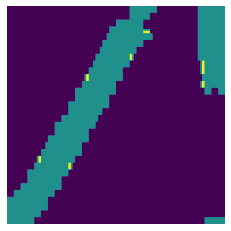

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
path4 = r'C:\Users\john\Downloads\cv2projects\4312pred2.jpg'
img = mpimg.imread(path4)
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

In [17]:

#myraster = 'C:/Users/john/Downloads/mass_buildings/ens/23579050_15WGS.tif'
#myraster = 'C:/Users/john/Downloads/mass_buildings/ens/10378675_15WGS.tif'
myraster = 'C:/Users/john/Documents/Masks/4312_predict3.jpg'
#myoutfile = 'C:/Users/john/Downloads/mass_buildings/ens/mygeojson1.GeoJSON'
myoutfile = 'C:/Users/john/Documents/Masks/myshapeout3.shp'


In [18]:
# mask to json or shapefile

mask = None
with rasterio.Env():
    with rasterio.open(myraster) as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))
        
# The result is a generator of GeoJSON features
        
geoms = list(results)

# print the very first feature
print(geoms[0])
#{'geometry': {'type': 'Polygon', 'coordinates': [[(202086.577, 90534.3504440678), (202086.577, 90498.96207),
 #                                                  (202121.96537406777, 90498.96207), (202121.96537406777, 90534.3504440678),
  #                                                 (202086.577, 90534.3504440678)]]}, 'properties': {'raster_val': 170.52000427246094}}
    

# Create geopandas Dataframe and enable easy to save as geojson, ESRI shapefile etc.
gpd_polygonized_raster  = gp.GeoDataFrame.from_features(geoms[:-6])

# Ensayo de geodataframe a geojson
#gpd_polygonized_raster.to_file(myoutfile, driver='GeoJSON')

gpd_polygonized_raster.to_file(myoutfile, driver='ESRI Shapefile')

print("Archivo convertido con éxito")


c:\users\john\.conda\envs\py37\lib\site-packages\rasterio\__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


{'properties': {'raster_val': 6.0}, 'geometry': {'type': 'Polygon', 'coordinates': [[(0.0, 0.0), (0.0, 1.0), (1.0, 1.0), (1.0, 0.0), (0.0, 0.0)]]}}
Archivo convertido con éxito


In [ ]:
# once in raster it should be dissolved

from shapely.geometry import shape, mapping
from shapely.ops import unary_union
import fiona
import itertools
with fiona.open('cb_2013_us_county_20m.shp') as input:
    # preserve the schema of the original shapefile, including the crs
    meta = input.meta
    with fiona.open('dissolve.shp', 'w', **meta) as output:
        # groupby clusters consecutive elements of an iterable which have the same key so you must first sort the features by the 'STATEFP' field
        e = sorted(input, key=lambda k: k['properties']['STATEFP'])
        # group by the 'STATEFP' field 
        for key, group in itertools.groupby(e, key=lambda x:x['properties']['STATEFP']):
            properties, geom = zip(*[(feature['properties'],shape(feature['geometry'])) for feature in group])
            # write the feature, computing the unary_union of the elements in the group with the properties of the first element in the group
            output.write({'geometry': mapping(unary_union(geom)), 'properties': properties[0]})
            


In [12]:
# Simplify and smooth polygons and polylines

import rasterio
from rasterio.features import shapes
import geopandas as gp

#simplified_shp = 'C:/Users/john/Downloads/mass_buildings/ens/simplifiedpolygon.shp'
simplified_shp = 'C:/Users/john/Documents/Masks/simplifiedpolygon2.shp'

d = gp.read_file(myoutfile)
x = d.buffer(0.0001)

tolerance = 0.00005
simplified = x.simplify(tolerance, preserve_topology=True)
simplified.to_file(simplified_shp)
print("se ha generado el archivo simplificado con éxito")


se ha generado el archivo simplificado con éxito


In [34]:

import fiona

bin_closing = 'C:/Users/john/Downloads/mass_buildings/ens/10378675_15WGS.tif'
outshapefile = 'C:/Users/john/Downloads/mass_buildings/ens/outshapeLine.shp'


results = ({'geometry':s, 'properties': {'id': v}}
for i, (s, v) in enumerate(shapes(bin_closing, mask=None, connectivity=8, transform=src.transform)))
geoms = list(results)
schema= {
      'geometry': 'LineString', 
      'properties': {'id': 'int'}
        }

with fiona.open(outshapefile, 'w', crs=src.crs, driver='ESRI Shapefile', schema = schema) as output:
        for i, g in enumerate(geoms):
            poly = shapes(g['geometry'])

            # id 1 is actually masked (black part) of bitmap, dont consider it
            if g['properties']['id'] == 1.0 and poly.is_valid:                

                # dont process small polygons
                if len(poly.exterior.coords) < 10:
                    continue

                newline = {}

                # try smoothing polygon
                fx = poly.buffer(50, 2).buffer(-50, 3)

                if fx.is_empty:
                    continue

                # create centerline from smoothen polygon
                geo = Centerline(fx, 10).createCenterline()

                if geo.is_empty:
                    continue                              

                newline['geometry'] = mapping(geo)
                newline['properties'] = {'id': i + 1}
                output.write(newline)
                
                

AttributeError: 'str' object has no attribute 'dtype'

In [6]:
## Not georeferenced mask
from PIL import Image # (pip install Pillow)

def create_sub_masks(mask_image):
    width, height = mask_image.size

    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]

            # If the pixel is not black...
            if pixel != (0, 0, 0):
                # Check to see if we've created a sub-mask...
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                   # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks



In [8]:
mymask = 'C:/Users/john/Downloads/mass_roads/train/results/10078705_15.tif'

mask_result = Image.open(mymask)
#mask_result.show()

create_sub_masks(mask_result)

TypeError: 'int' object is not subscriptable

In [31]:
import shp2centerline
import fiona
from shapely.geometry import Polygon
from centerline.geometry import Centerline

myshp = 'C:/Users/john/Documents/Masks/dissolve2.shp'

polygon = fiona.open(myshp)
print(shape.schema)

#polygon = Polygon([[0, 0], [0, 4], [4, 4], [4, 0]])
#>>> attributes = {"id": 1, "name": "polygon", "valid": True}
centerline = Centerline(polygon, **attributes)
#>>> centerline.id == 1


ModuleNotFoundError: No module named 'centerline.geometry'; 'centerline' is not a package